## Import packages and initial DataFrame

In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'large','id4':'large'}
true_identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'strict'}
covariates = ['X1','X2','X3','X4','X5']

## Generate covariates, treatment and associations with outcome

In [2]:
# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

## Generate subdatasets A and B with common records

In [3]:
common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(true_identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

# generate noise
A['id1'] = np.random.normal(loc = 0, scale = 10, size = A.shape[0]).astype(int)
A['id2'] = np.random.normal(loc = 0, scale = 10, size = A.shape[0]).astype(int)
A['id3'] = np.random.normal(loc = 1000, scale = 1000, size = A.shape[0]).astype(int)
A['id4'] = np.random.normal(loc = 1000, scale = 1000, size = A.shape[0]).astype(int)
B['id1'] = np.random.normal(loc = 0, scale = 10, size = B.shape[0]).astype(int)
B['id2'] = np.random.normal(loc = 0, scale = 10, size = B.shape[0]).astype(int)
B['id3'] = np.random.normal(loc = 1000, scale = 1000, size = B.shape[0]).astype(int)
B['id4'] = np.random.normal(loc = 1000, scale = 1000, size = B.shape[0]).astype(int)

# delete some family names
A.loc[np.random.choice(np.arange(A.shape[0]), size=250), 'family_name'] = ''

## Write fucntions to compare linking variables among records
- Levenshtein similarity
- Jaro Winkler similarity
- Strict equality
- Large equality

In [4]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

## Write fucntions to compute the propensity score estimates based on covariates in a DataFrame

In [5]:
def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

In [6]:
B['propensity_score'] = propensity_score(B, covariates, None, False)

## Compute the cartesian product of all records in A and B
- add the source index (in A or B)
- add the linking score for each pair of records
- compute comparison vectors
- compute the probability of having same linking variables (at all and for matches)

In [7]:
AB = B.merge(A, how='cross', suffixes=("_B", "_A")) # preserve order of left keys: B file
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

unmatch = np.array(comparison_vectors_only.sum(axis=0) / len(comparison_vectors_only)) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparison_vectors_only, np.log2(match/unmatch)) + np.multiply(1-comparison_vectors_only, np.log2((1-match)/(1-unmatch)))).sum(axis=1)

AB

,name,family_name_B,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,...,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison,id4_comparison,linking_score
0,Облачко,Кучевое,RU,1976,1,44,4.006678,0.394429,1.048923,1.355760,...,0,0,1,0,0,0,0,0,0,-28.997616
1,Облачко,Кучевое,RU,1976,1,44,4.006678,0.394429,1.048923,1.355760,...,1,0,0,0,0,0,0,0,0,-33.238236
2,Облачко,Кучевое,RU,1976,1,44,4.006678,0.394429,1.048923,1.355760,...,2,0,0,1,1,0,0,0,0,-17.217667
3,Облачко,Кучевое,RU,1976,1,44,4.006678,0.394429,1.048923,1.355760,...,3,0,0,0,0,0,0,0,0,-33.238236
4,Облачко,Кучевое,RU,1976,1,44,4.006678,0.394429,1.048923,1.355760,...,4,0,1,1,1,0,0,0,0,-12.977047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Люда,Албегова,RU,1961,1,59,3.548394,0.613293,1.999017,0.347994,...,2795,0,1,1,0,0,0,0,0,-21.762562
6159996,Люда,Албегова,RU,1961,1,59,3.548394,0.613293,1.999017,0.347994,...,2796,0,0,0,0,0,0,0,0,-33.238236
6159997,Люда,Албегова,RU,1961,1,59,3.548394,0.613293,1.999017,0.347994,...,2797,0,1,0,0,0,0,0,0,-28.997616
6159998,Люда,Албегова,RU,1961,1,59,3.548394,0.613293,1.999017,0.347994,...,2798,0,1,0,0,0,0,0,0,-28.997616


In [8]:
comparison_vectors_only

,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison,id4_comparison
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
6159995,0,1,1,0,0,0,0,0
6159996,0,0,0,0,0,0,0,0
6159997,0,1,0,0,0,0,0,0
6159998,0,1,0,0,0,0,0,0


## Build the initial linkage
- find perfect comparisons between linking variables
- remove duplicates coming from A or from B
- on linked records, compute the propensity score
- build z0 the initial linkage estimates
- compute the true linkage (based on the common records subdataset built at the start)

For each record in $B$ we find the best match in $A$

Produce the linkage variable $$z_j = \left\{
    \begin{array}{ll}
        i & \text{if } \{i,j\} \text{ are matched} \\
        j + n_A & \text{otherwise.}
    \end{array}
\right.$$

In [9]:
where_good_comparisons = AB[comparison_vectors_only[['family_name_comparison', 'was_assigned_female_comparison', 'country_comparison', 'birth_year_comparison']].all(axis=1)]

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

z_init = -np.ones(B.shape[0])
z_init[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index

Because the linkage estimate is built by removing duplicates from A and B to enforce 1-2-1 matching we miss some matches and make some errors. We evaluate the proportion of good estimations below:

In [10]:
(z_init == true_linkage_z).sum() / len(true_linkage_z)

0.5381818181818182

In [11]:
comparison_vectors_only[comparison_vectors_only.sum(axis=1) >=4 ]

,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison,id4_comparison
418,0,1,1,1,1,0,0,0
772,0,1,1,1,1,0,0,0
1589,1,1,1,1,0,0,0,0
1693,0,0,1,1,0,1,0,1
1884,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...
6157915,0,1,1,1,0,1,0,0
6158417,0,1,1,1,0,1,0,0
6158722,1,1,1,1,0,0,0,0
6159925,0,1,1,1,0,0,1,0


In [12]:
def update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha):
    comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    new_theta_u = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + previous_a, (1-comparison_vectors_for_non_matches).sum(axis=0) + previous_b)
    comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    new_theta_m = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + previous_a, (1-comparison_vectors_for_matches).sum(axis=0) + previous_b)
    return new_theta_u, new_theta_m

def update_coef_outcome_match(cartesian_product_AB, links, pairs, covariates, previous_z, previous_a_sigma, previous_b_sigma, previous_beta0, previous_beta1, previous_alpha):
    data_for_matches = cartesian_product_AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = propensity_score(data_for_matches, covariates, None, False)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    K = np.concatenate([np.ones(len(outcome_for_matches)).reshape(-1,1), linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(previous_z>=0)
    sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(outcome_for_matches - K @ np.array([previous_beta0, previous_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(3) ) # scipy.linalg.fractional_matrix_power(Sigma_beta, 0.5)
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    return new_beta0, new_beta1, new_alpha

def update_coef_outcome_unmatch(n_A, cartesian_product_AB, links, pairs, previous_z, previous_a_sigma2, previous_b_sigma2, previous_mu2):
    data_for_non_matches = cartesian_product_AB[~pairs.isin(links)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    n_AB = sum(previous_z>=0)
    new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (n_A - n_AB)/2, previous_b_sigma2 + sum((outcome_for_non_matches - previous_mu2)**2)/2)
    sigma_mu2_square = 1/((n_A - n_AB)/new_sigma2_square + 1)
    m_mu2 = sigma_mu2_square * (outcome_for_non_matches).sum() / new_sigma2_square
    new_mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    return new_mu2, new_sigma2_square
        
def update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi):
    # print("previous_theta_m - previous_theta_u", previous_theta_m, previous_theta_u)
    
    w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
    Betas = np.array([previous_beta0, previous_beta1, previous_alpha])
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)

    #print(comparison_vectors[w1>2])
    # print("ICI = 3", (w1+w2)[comparison_vectors.sum(axis=1)==3])
    # print("ICI = 4", (w1+w2)[comparison_vectors.sum(axis=1)==4])
    # print("ICI = 5", (w1+w2)[comparison_vectors.sum(axis=1)==5])
    # print("ICI = 6", (w1+w2)[comparison_vectors.sum(axis=1)==6])
    # print("ICI = 7", (w1+w2)[comparison_vectors.sum(axis=1)==7])
    # print("ICI < 1",(w1+w2)[comparison_vectors.sum(axis=1)<1])
    #print(comparison_vectors[w1<0])

    probabilities = np.array(np.exp(w1) * (distr_linked_outcomes / distr_non_linked_outcomes)) # np.array(np.exp(w1 + w2))
    probabilities = probabilities.reshape(n_B, n_A) # REMARK: SOME VALUE VERY HIGH WHY ???
    print(np.max(probabilities, axis=1))
    n_AB_1 = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(n_B) ])

    #n_AB_2 = np.ones(n_B) * 1e9/2 # FORCE THE NUMBER OF MATCH TO REMAIN LOW
    proba_for_unmatch_1 = (n_A - n_AB_1) * (n_B - n_AB_1 - 1 + previous_beta_pi) / (n_AB_1 + previous_alpha_pi)
    print(proba_for_unmatch_1)
    #proba_for_unmatch_2 = (n_A - n_AB_2) * (n_B - n_AB_2 - 1 + previous_beta_pi) / (n_AB_2 + previous_alpha_pi)
    #
    # probabilities_to_print = np.concatenate([probabilities, proba_for_unmatch_2.reshape(-1,1)], axis=1)
    # probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T # j in row, all A index value + -1 in column
    # plt.figure(figsize=(30,3))
    # sns.heatmap(probabilities_to_print)
    # plt.show()
    # plt.figure(figsize=(30,3))
    # sns.heatmap(probabilities_to_print[:,2789:])
    # plt.show()
    #
    new_z = []
    taken = np.array([])
    for j in range(n_B):
        possible_values = list(set(np.arange(n_A)) - set(taken))
        proba = list(probabilities[j,:][possible_values])
        possible_values.append(-1)
        proba.append(proba_for_unmatch_1[j])

        test = proba / sum(proba)
        print("+ grosses proba",np.sort(test)[::-1][:5])
        print("max proba", np.max(test))
        print("arg max proba", np.argmax(test))
        print("size of list",len(test))
        print("associated possible value to max", possible_values[np.argmax(test)])
        val = choices(possible_values, weights = proba / sum(proba))[0]
        print(val)
        #valuu = np.random.choice(possible_values, size=100, p = proba / sum(proba))
        #print(valuu)
        if val != -1:
            taken = np.append(taken, val)
        new_z.append(val)
    new_z = np.array(new_z)
    return new_z

In [24]:
print(AB[(AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ])

           name family_name_B country_B  birth_year_B  was_assigned_female_B  \
2733462  Cedric         Perez        FR          2017                      0   

         X1        X2       X3        X4        X5  ...  source_index_A  \
2733462   3  1.798267  0.03536  2.799951  0.134367  ...             662   

         family_name_comparison  was_assigned_female_comparison  \
2733462                       1                               1   

         country_comparison  birth_year_comparison  id1_comparison  \
2733462                   1                      1               0   

        id2_comparison  id3_comparison id4_comparison  linking_score  
2733462              0               0              0       2.772349  

[1 rows x 36 columns]


In [23]:
common_records[common_records.name=='Cedric']

,name,family_name,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,Y
3924,Cedric,Von Gunten,CH,1983,0,37,2.956847,-0.391673,-0.737846,1.474895,0,-10.122143


In [17]:
A.iloc[662,:]

family_name               Perez
was_assigned_female           0
country                      FR
birth_year                 2017
Y                      0.157449
id1                         -11
id2                          -8
id3                        1154
id4                        1776
Name: 662, dtype: object

In [18]:
B.iloc[976,:]

name                     Cedric
family_name               Perez
country                      FR
birth_year                 2017
was_assigned_female           0
X1                            3
X2                     1.798267
X3                      0.03536
X4                     2.799951
X5                     0.134367
treatment                     1
id1                          -4
id2                           0
id3                         445
id4                         207
propensity_score       0.706116
Name: 976, dtype: object

In [23]:
AB[ (AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ]

,name,family_name_B,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,...,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison,id4_comparison,linking_score


In [24]:
probabilities[ (AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2200 but corresponding boolean dimension is 6160000

In [28]:
intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score) # propensity_score(cartesian_product_AB, covariates, None, False)
interaction_term = records_treatment * records_propensity_score
X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
Betas = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
residuals = AB.Y - X @ Betas.T
estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
distr_non_linked_outcomes = scipy.stats.norm.pdf(AB.Y, scipy.stats.norm.rvs(0, 1), 10000)
w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
print(w2[ (AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ])
w1 = ( np.multiply( comparison_vectors_only, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors_only, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
print(w1[ (AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ])
probabilities = np.array(np.exp(w1+w2))
print((AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez'))
print(probabilities[ (AB.name=='Cedric') & (AB.family_name_B=='Perez') & (AB.family_name_A=='Perez') ])
person_of_interest = AB.iloc[probabilities.argmax(), :]
probabilities = probabilities.reshape(B.shape[0], A.shape[0])
print(probabilities[976,662])

n_AB_1 = np.array([ (np.delete(z_init, j)>=0).sum() for j in range(B.shape[0]) ])
proba_for_unmatch_1 = (A.shape[0] - n_AB_1) * (B.shape[0] - n_AB_1 - 1 + 1) / (n_AB_1 + 1)
new_z = z_init.copy()

j = 976
print("j:", j)

not_possible_values = list( set(np.delete(z_init, j).astype(int)) - set([-1]) ) # should be index of proba vector later so we should be sure that -1 is not in there

proba = probabilities[j,:].copy()
print(proba[662])
proba[not_possible_values]  = 0
proba = np.append(proba, proba_for_unmatch_1[j])

idx_max_proba = np.argpartition(proba, -5)[-5:]
possible_values = np.arange(A.shape[0])# possible values - taken values (remove also -1)
possible_values = np.append(possible_values, -1)
print("possible values", possible_values)
print("max proba", max(proba))
print("5 argmax proba", np.argpartition(proba, -5)[-5:])
print("5 most probable possible values", possible_values[np.argpartition(proba, -5)[-5:]])
print("5 highest proba", proba[np.argpartition(proba, -5)[-5:]])

[]
Series([], dtype: float64)
0          False
1          False
2          False
3          False
4          False
           ...  
6159995    False
6159996    False
6159997    False
6159998    False
6159999    False
Length: 6160000, dtype: bool
[]
5.0141869123200804e-08
j: 976
5.0141869123200804e-08
possible values [   0    1    2 ... 2798 2799   -1]
max proba 3898.990752972259
5 argmax proba [1957 2413  292  301 2800]
5 most probable possible values [1957 2413  292  301   -1]
5 highest proba [  20.43503661   22.37249937   30.78955697 1802.57964956 3898.99075297]


[6.41302942 6.82622471 6.82877076 ... 6.60210631 4.87424293 6.65228888]
2732800   -20.099616
2732801   -23.038990
2732802   -18.024032
2732803   -23.038990
2732804    -8.719104
             ...    
2735595   -15.084658
2735596   -23.038990
2735597   -20.099616
2735598   -20.099616
2735599   -15.084658
Length: 2800, dtype: float64
[1.13760384e-06 9.09673540e-08 1.37391445e-05 ... 1.37437771e-06
 2.44176898e-07 2.17705053e-04]
4.7246585331776164e-08
4.7246585331776164e-08


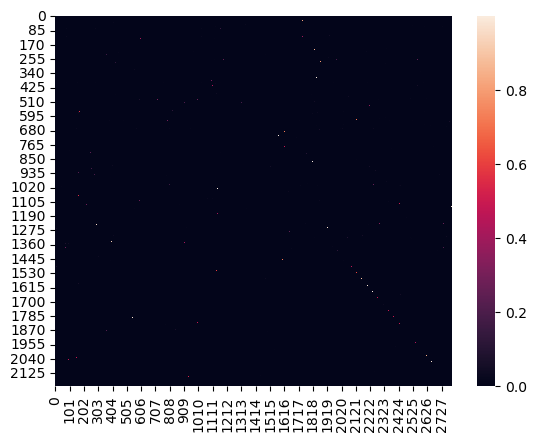

In [21]:
j = 976
data_idx = AB.source_index_B==j

intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score) # propensity_score(cartesian_product_AB, covariates, None, False)
interaction_term = records_treatment * records_propensity_score
X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
Betas = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
residuals = AB.Y - X @ Betas.T
estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
distr_non_linked_outcomes = scipy.stats.norm.pdf(AB.Y, scipy.stats.norm.rvs(0, 1), 10000)
w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
print(w2[ data_idx ])
w1 = ( np.multiply( comparison_vectors_only, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors_only, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
print(w1[ data_idx ])
probabilities = np.array(np.exp(w1+w2))
print(probabilities[ data_idx ])
person_of_interest = AB.iloc[probabilities.argmax(), :]
probabilities = probabilities.reshape(B.shape[0], A.shape[0])
print(probabilities[976,662])
proba = probabilities[j,:].copy()
print(proba[662])

probabilities_to_print = probabilities.copy()

probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T # j in row, all A index value + -1 in column

sns.heatmap(probabilities_to_print)
plt.show()


In [ ]:
previous_theta_m = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])
previous_theta_u = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

ww1 = ( np.multiply( comparison_vectors_only, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors_only, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
    

In [37]:
def update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi):
    #w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
    
    #print("where w1 is max cartesian product",cartesian_product_AB.iloc[w1.argmax(), :])
    #print("correpsonding comp vectors",comparison_vectors.iloc[w1.argmax(), :])


    #intercept = np.ones(AB.shape[0])
    #records_treatment =  np.array(AB.treatment)
    # records_propensity_score = np.array(AB.propensity_score) # propensity_score(cartesian_product_AB, covariates, None, False)
    # interaction_term = records_treatment * records_propensity_score
    # X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    
    intercept = np.ones(cartesian_product_AB.shape[0])
    records_treatment =  np.array(cartesian_product_AB.treatment)
    records_propensity_score = np.array(cartesian_product_AB.propensity_score) # propensity_score(cartesian_product_AB, covariates, None, False)
    interaction_term = records_treatment * records_propensity_score
    X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)


    Betas = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))

    
    #Betas = np.array([previous_beta0, previous_beta1, previous_alpha])
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    #distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, scipy.stats.norm.rvs(0, 1), 10000)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)

    #probabilities = np.array(np.exp(w1) * (distr_linked_outcomes / distr_non_linked_outcomes))

    previous_theta_m = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])
    previous_theta_u = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

    ww1 = ( np.multiply( comparison_vectors_only, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors_only, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
        
   
    w1 = ( np.multiply( comparison_vectors_only, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors_only, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    probabilities = np.array(np.exp(w1+w2))
    probabilities2 = np.array(np.exp(ww1+w2))

    #print("where exp w1+w2 is max cartesian product", person_of_interest)
    #print("correpsonding comp vectors",comparison_vectors.iloc[probabilities.argmax(), :])

    probabilities = probabilities.reshape(n_B, n_A)
    probabilities2 = probabilities2.reshape(n_B, n_A)

    probabilities_to_print = probabilities.copy()
    probabilities_to_print2 = probabilities2.copy()

    probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T # j in row, all A index value + -1 in column
    probabilities_to_print2 = np.divide(probabilities_to_print2.T, probabilities_to_print2.sum(axis=1)).T # j in row, all A index value + -1 in column

    sns.heatmap(probabilities_to_print)
    plt.show()
    sns.heatmap(probabilities_to_print2)
    plt.show()

    print(probabilities[3,:])
    print(probabilities[13,:])

    #print("probabilities.max() giving the person of interest", probabilities.max())
    #print("same person with the other proba reprez", probabilities[person_of_interest.source_index_B, person_of_interest.source_index_A])

    n_AB_1 = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(n_B) ])
    proba_for_unmatch_1 = (n_A - n_AB_1) * (n_B - n_AB_1 - 1 + previous_beta_pi) / (n_AB_1 + previous_alpha_pi)
    new_z = previous_z.copy()

    j = 976 #person_of_interest.source_index_B
    print("j:", j)

    not_possible_values = list( set(np.delete(previous_z, j).astype(int)) - set([-1]) ) # should be index of proba vector later so we should be sure that -1 is not in there

    proba = probabilities[j,:].copy()
    proba[not_possible_values]  = 0
    #print("max proba", max(proba))
    #print("argmax proba", proba.argmax())

    #print("index where Aidx and Bidx", cartesian_product_AB[(cartesian_product_AB.source_index_B==j) & (cartesian_product_AB.source_index_A==proba.argmax())].index)
    #print("Look at comparison vectors for best matches \n",comparison_vectors.iloc[cartesian_product_AB[(cartesian_product_AB.source_index_B==j) & (cartesian_product_AB.source_index_A==proba.argmax())].index,:])
    
    #proba = list(probabilities[j,:][possible_values])
    #possible_values.append(-1)
    proba = np.append(proba, proba_for_unmatch_1[j])

    idx_max_proba = np.argpartition(proba, -5)[-5:]
    # cartesian_product_AB[(cartesian_product_AB.source_index_B==j) & (cartesian_product_AB.source_index_A==proba.argmax())].index = probabilities.argmax from before reshaping
    #print(np.array(possible_values)[idx_max_proba], np.array(proba)[idx_max_proba]/sum(np.array(proba)[idx_max_proba]))
    possible_values = np.arange(n_A)# possible values - taken values (remove also -1)
    possible_values = np.append(possible_values, -1)
    print("possible values", possible_values)
    #val = choices(np.array(possible_values)[idx_max_proba], weights = np.array(proba)[idx_max_proba])[0]

    print("max proba", max(proba))
    print("5 argmax proba", np.argpartition(proba, -5)[-5:])
    print("5 most probable possible values", possible_values[np.argpartition(proba, -5)[-5:]])
    print("5 highest proba", proba[np.argpartition(proba, -5)[-5:]])
    # val = choices(possible_values, weights = proba)[0]
    val1 = choices(possible_values[np.argpartition(proba, -5)[-5:]], weights = proba[np.argpartition(proba, -5)[-5:]])[0]
    print("val1",val1)
    val2 = choices(possible_values, weights = proba)[0]
    print("val2",val2)
    val3 = np.random.choice(possible_values, size=15, p = proba / sum(proba))
    print("val3",val3)
    # WHY PROBA ARE SO HIGH??? SOMETIMES

    new_z[j] = val1

    # for j in range(n_B):
    #     possible_values = list(set(np.arange(n_A)) - set(np.delete(previous_z, j)) - set({-1})) # possible values - taken values (remove also -1)
    #     proba = list(probabilities[j,:][possible_values])
    #     possible_values.append(-1)
    #     proba.append(proba_for_unmatch_1[j])
    #     print("max proba", max(proba))
    #     print("5 max proba", np.array(proba)[np.argpartition(proba, -5)[-5:]])
    #     idx_max_proba = np.argpartition(proba, -5)[-5:]
    #     print("Look at comparison vectors for best matches \n",comparison_vectors.iloc[idx_max_proba,:])
    #     #print(np.array(possible_values)[idx_max_proba], np.array(proba)[idx_max_proba]/sum(np.array(proba)[idx_max_proba]))
    #     val = choices(np.array(possible_values)[idx_max_proba], weights = np.array(proba)[idx_max_proba])[0]
    #     #print(val)
    #     new_z[j] = val
    return new_z

In [119]:
# probabilities_to_print = np.concatenate([probabilities, proba_for_unmatch.reshape(-1,1)], axis=1)

# probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T # j in row, all A index value + -1 in column

# sns.heatmap(probabilities_to_print)
# plt.show()

# sns.heatmap(probabilities_to_print[:,2799:])
# plt.show()

In [ ]:
# TODO: check that propensity score only on B !!!
# block all parameterst to understand why probabilities evolve like thsi! there should be a problem

paraneters needed to update linkage (should stay fixed)
 2800 2200 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4] [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4] -1.1517868958617452 0.35868069148302134 -0.2602106722277471 -0.11862089987123715 10000 1 1
previous linkage vector [ 1.589e+03 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]


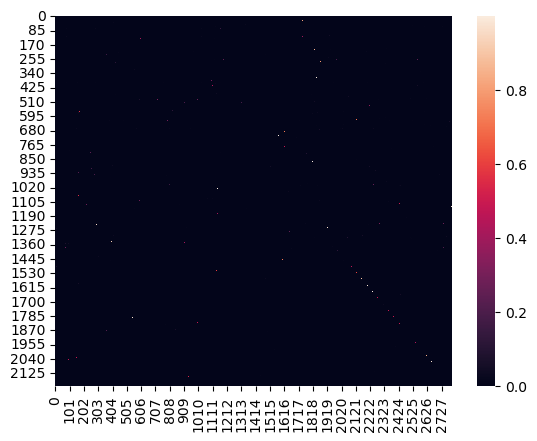

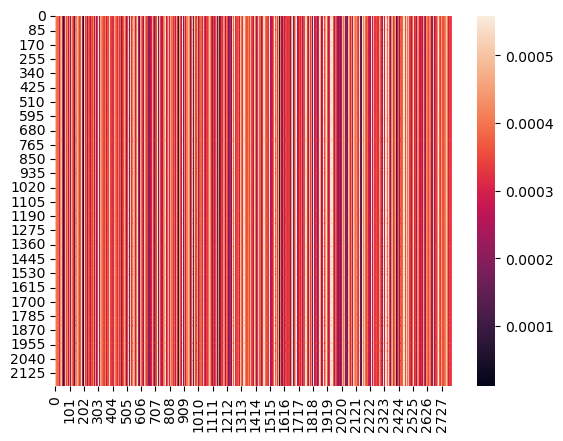

[1.07563231e-06 8.62561068e-08 8.64899604e-08 ... 1.29722642e-06
 2.43209615e-07 1.36411504e-06]
[1.11076265e-06 8.74551703e-08 1.32082161e-05 ... 1.33077458e-06
 2.59247027e-07 2.10379982e-04]
j: 976
possible values [   0    1    2 ... 2798 2799   -1]
max proba 3898.990752972259
5 argmax proba [2635  301 2413  292 2800]
5 most probable possible values [2635  301 2413  292   -1]
5 highest proba [  19.24250139 1706.9524177    20.87318708   27.86593998 3898.99075297]
val1 -1
val2 301
val3 [301  -1 301 301 301  -1 301 301  -1  -1  -1  -1  -1  -1  -1]
paraneters needed to update linkage (should stay fixed)
 2800 2200 [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4] [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4] -1.1517868958617452 0.35868069148302134 -0.2602106722277471 -0.11862089987123715 10000 1 1
previous linkage vector [ 1.589e+03 -1.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00 -1.000e+00]


KeyboardInterrupt: 

In [38]:
def Gibbs_Sampler(n_A, n_B, z_init, cartesian_product_AB, comparison_vectors, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init):

    intercept = np.ones(cartesian_product_AB.shape[0])
    records_treatment =  np.array(cartesian_product_AB.treatment)
    records_propensity_score = np.array(cartesian_product_AB.propensity_score) # propensity_score(cartesian_product_AB, covariates, None, False)
    interaction_term = records_treatment * records_propensity_score
    X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

    linkage_k = [z_init]
    beta0_k = [beta0_init]
    beta1_k = [beta1_init]
    alpha_k = [alpha_init]
    previous_a_sigma = a_sigma_init
    previous_b_sigma = b_sigma_init
    previous_a_sigma2 = a_sigma2_init
    previous_b_sigma2 = b_sigma2_init
    previous_a = a_init
    previous_b = b_init
    previous_alpha_pi = alpha_pi_init
    previous_beta_pi = beta_pi_init
    theta_u_k = [np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
    theta_m_k = [np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
    mu2_k = [mu2_init]
    sigma2_square_k = [10000]

    for _ in range(50):

        previous_z = linkage_k[-1]
        previous_beta0 = beta0_k[-1]
        previous_beta1 = beta1_k[-1]
        previous_alpha = alpha_k[-1]

        idx_match_A = previous_z[previous_z>=0]
        idx_match_B = np.nonzero(previous_z>=0)[0]
        links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
        pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

        #start1 = time.time()
        #new_theta_u, new_theta_m = update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha)
        #end1 = time.time()
        #print("1", end1-start1)
        # theta_u_k.append(new_theta_u)
        # theta_m_k.append(new_theta_m)
        # theta_u_k.append(np.array([0.5, 0.5, 0.5, 0.5]))
        # theta_m_k.append(np.array([0.5, 0.5, 0.5, 0.5]))

        # new_beta0, new_beta1, new_alpha = update_coef_outcome_match(cartesian_product_AB, links, pairs, covariates, previous_z, previous_a_sigma, previous_b_sigma, previous_beta0, previous_beta1, previous_alpha)
        # beta0_k.append(new_beta0)
        # beta1_k.append(new_beta1)
        # alpha_k.append(new_alpha)

        previous_mu2 = mu2_k[-1]

        # new_mu2, new_sigma2_square = update_coef_outcome_unmatch(n_A, cartesian_product_AB, links, pairs, previous_z, previous_a_sigma2, previous_b_sigma2, previous_mu2)
        # print("sigma square", new_sigma2_square)
        # mu2_k.append(new_mu2)
        # sigma2_square_k.append(new_sigma2_square)

        previous_theta_m = theta_m_k[-1]
        previous_theta_u = theta_u_k[-1]
        previous_sigma2_square = sigma2_square_k[-1]

        print("paraneters needed to update linkage (should stay fixed)\n", n_A, n_B, previous_theta_m, previous_theta_u, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi)
        print("previous linkage vector", previous_z)
        new_linkage = update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi)
        linkage_k.append(new_linkage)

        # new_theta_u, new_theta_m = update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha)
        # theta_u_k.append(new_theta_u)
        # theta_m_k.append(new_theta_m) 
        

    return linkage_k

n_A = A.shape[0]
n_B = B.shape[0]
beta0_init, beta1_init, alpha_init = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, a_init, b_init, alpha_pi_init, beta_pi_init = 1, 1, 1, 1, 1, 1, 1, 1
mu2_init = scipy.stats.norm.rvs(0, 1)
zzz = Gibbs_Sampler(n_A, n_B, z_init, AB, comparison_vectors_only, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init)
zzz   

In [ ]:
(zzz[-1] == true_linkage_z).sum() / len(true_linkage_z)

0.6004545454545455

In [84]:
(zzz[-1] == true_linkage_z).sum() / len(true_linkage_z)

0.5781818181818181

In [25]:
def Gibbs_Sampler(n_A, n_B, z_init, cartesian_product_AB, comparison_vectors, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init):

    intercept = np.ones(cartesian_product_AB.shape[0])
    records_treatment =  np.array(cartesian_product_AB.treatment)
    records_propensity_score = propensity_score(cartesian_product_AB, covariates, None, False)
    interaction_term = records_treatment * records_propensity_score
    X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

    linkage_k = [z_init]
    beta0_k = [beta0_init]
    beta1_k = [beta1_init]
    alpha_k = [alpha_init]
    previous_a_sigma = a_sigma_init
    previous_b_sigma = b_sigma_init
    previous_a_sigma2 = a_sigma2_init
    previous_b_sigma2 = b_sigma2_init
    previous_a = a_init
    previous_b = b_init
    previous_alpha_pi = alpha_pi_init
    previous_beta_pi = beta_pi_init
    theta_u_k = [np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
    theta_m_k = [np.array([0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4])]
    mu2_k = [mu2_init]
    sigma2_square_k = []

    for _ in tqdm.tqdm(range(50)):

        previous_z = linkage_k[-1]
        #print(sum(previous_z>=0))
        previous_beta0 = beta0_k[-1]
        previous_beta1 = beta1_k[-1]
        previous_alpha = alpha_k[-1]

        idx_match_A = previous_z[previous_z>=0]
        idx_match_B = np.nonzero(previous_z>=0)[0]
        links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
        pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

        #start1 = time.time()
        #new_theta_u, new_theta_m = update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha)
        #end1 = time.time()
        #print("1", end1-start1)
        # theta_u_k.append(new_theta_u)
        # theta_m_k.append(new_theta_m)
        # theta_u_k.append(np.array([0.5, 0.5, 0.5, 0.5]))
        # theta_m_k.append(np.array([0.5, 0.5, 0.5, 0.5]))

        new_beta0, new_beta1, new_alpha = update_coef_outcome_match(cartesian_product_AB, links, pairs, covariates, previous_z, previous_a_sigma, previous_b_sigma, previous_beta0, previous_beta1, previous_alpha)
        beta0_k.append(new_beta0)
        beta1_k.append(new_beta1)
        alpha_k.append(new_alpha)

        previous_mu2 = mu2_k[-1]

        new_mu2, new_sigma2_square = update_coef_outcome_unmatch(n_A, cartesian_product_AB, links, pairs, previous_z, previous_a_sigma2, previous_b_sigma2, previous_mu2)
        
        mu2_k.append(new_mu2)
        sigma2_square_k.append(new_sigma2_square)

        previous_theta_m = theta_m_k[-1]
        previous_theta_u = theta_u_k[-1]
        previous_sigma2_square = sigma2_square_k[-1]

        new_linkage = update_linkage(n_A, n_B, cartesian_product_AB, comparison_vectors, X, previous_z, previous_theta_m, previous_theta_u, covariates, previous_beta0, previous_beta1, previous_alpha, previous_mu2, previous_sigma2_square, previous_beta_pi, previous_alpha_pi)
        linkage_k.append(new_linkage)

        new_theta_u, new_theta_m = update_theta(comparison_vectors, links, pairs, previous_a, previous_b, previous_beta0, previous_beta1, previous_alpha)
        theta_u_k.append(new_theta_u)
        theta_m_k.append(new_theta_m) 
        

    return linkage_k

n_A = A.shape[0]
n_B = B.shape[0]
beta0_init, beta1_init, alpha_init = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, a_init, b_init, alpha_pi_init, beta_pi_init = 1, 1, 1, 1, 1, 1, 1, 1
mu2_init = scipy.stats.norm.rvs(0, 1)
zzz = Gibbs_Sampler(n_A, n_B, z_init, AB, comparison_vectors_only, a_sigma_init, b_sigma_init, a_sigma2_init, b_sigma2_init, beta0_init, beta1_init, alpha_init, covariates, a_init, b_init, alpha_pi_init, beta_pi_init, mu2_init)
zzz 

100%|██████████| 50/50 [03:53<00:00,  4.67s/it]


[array([-1.000e+00,  7.500e+01, -1.000e+00, ...,  2.797e+03, -1.000e+00,
        -1.000e+00]),
 array([ 2.044e+03,  7.500e+01, -1.000e+00, ...,  2.797e+03,  2.798e+03,
         2.799e+03]),
 array([ 763.,   75., 1324., ..., 2797.,  157.,  871.]),
 array([ 377.,   75.,  220., ..., 2797., 2798., 2799.]),
 array([2563.,   75.,  650., ..., 2797., 1769.,  871.]),
 array([ 377.,   75.,  302., ..., 2797., 2798., 2799.]),
 array([1348.,   75.,  603., ..., 2797., 1509.,  871.]),
 array([ 763.,   75.,  650., ..., 2797., 2798., 2799.]),
 array([ 868.,   75.,  603., ..., 2797., 1509.,  871.]),
 array([2044.,   75.,  262., ..., 2797., 2798., 2799.]),
 array([1952.,   75.,  603., ..., 2797.,  128.,  871.]),
 array([ 671.,   75.,  262., ..., 2797., 2798., 2799.]),
 array([ 763.,   75., 1290., ..., 2797., 1428.,  871.]),
 array([ 763.,   75.,  650., ..., 2797., 2798., 2799.]),
 array([  24.,   75.,  608., ..., 2797.,  128.,  871.]),
 array([ 763.,   75.,  302., ..., 2797., 2798., 2799.]),
 array([  24

In [26]:
(zzz[-1] == true_linkage_z).sum() / len(true_linkage_z)

0.19318181818181818

In [24]:
zzz[-1][zzz[-1]<0]

array([-1.])

In [15]:
(zzz[-1][zzz[-1]>=0] == true_linkage_z[true_linkage_z>=0]).sum() / len(true_linkage_z[true_linkage_z>=0])

/var/folders/_7/32t15g3d2h54d0ct6cssb9gh0000gn/T/ipykernel_1297/2313529753.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (zzz[-1][zzz[-1]>=0] == true_linkage_z[true_linkage_z>=0]).sum() / len(true_linkage_z[true_linkage_z>=0])


AttributeError: 'bool' object has no attribute 'sum'

In [ ]:
print(sum(zzz[-1]>=0))